In [3]:
import astropy.io.fits as fits
import numpy as np
import pandas
from astropy.table import unique,Table,setdiff,hstack,join,QTable
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import warnings
from scipy.stats import sem
import seaborn as sns
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord, angular_separation
from time import sleep
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename

# reals = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09_reals_zlt0.125.fits')
# reals.info()
# rands = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09_rands_rev_0.125.fits')
# rands.info()

In [2]:
sami = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09_sami_1.4.fits')
sami.info()

<Table length=676>
     name      dtype     unit      class     n_bad
------------- ------- --------- ------------ -----
        CATID   int64           MaskedColumn     0
           RA float32       deg       Column     0
          DEC float32       deg       Column     0
       Z_SPEC float32                 Column     0
  RE_CIRC_KPC float64                 Column     0
        ELLIP float64           MaskedColumn    18
   LAMBDAR_RE float64           MaskedColumn   286
       RA_RAD float32       rad       Column     0
      DEC_RAD float32       rad       Column     0
ANG_DIAM_DIST float64 Mpc / rad       Column     0
5_RE_CIRC_MPC float64                 Column     0


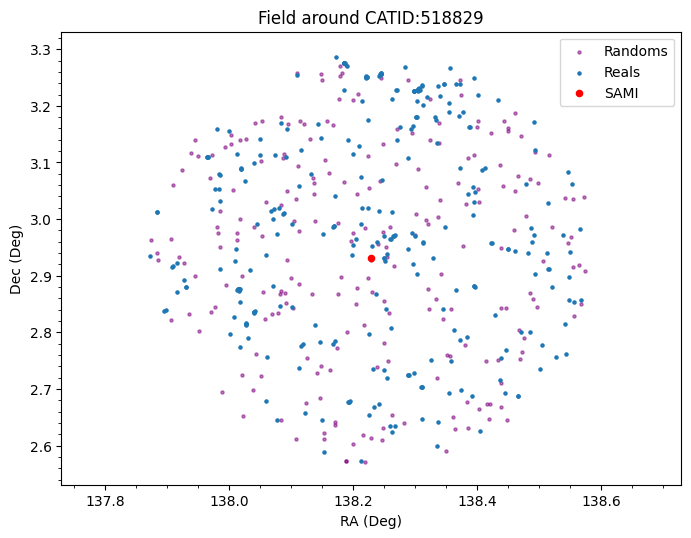

In [21]:
# look at a random galaxy
def field_inspect(index):
    plt.figure(figsize=(8,6),dpi=100)
    plt.scatter(rands['RAND_HSC_RA'][index],rands['RAND_HSC_DEC'][index],label='Randoms',alpha=0.5,c='purple',s=5)
    plt.scatter(reals['HSC_RA'][index],reals['HSC_DEC'][index],label='Reals',s=5)
    plt.scatter(rands['RA'][index],rands['DEC'][index],label='SAMI',c='r',s=20)
    plt.legend()
    plt.xlabel("RA (Deg)")
    plt.ylabel("Dec (Deg)")
    plt.xlim(rands['RA'][index]-.5,rands['RA'][index]+.5)
    plt.ylim(rands['DEC'][index]-.4,rands['DEC'][index]+.4)
    plt.title("Field around CATID:{}".format(rands['CATID'][index]))
    plt.minorticks_on()
    
    filename = "/suphys/fscu5535/HSC_work/figures/1MpcfieldforCATID{}.png".format(rands['CATID'][index])
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250) 
    
    return


field_inspect(500)

    

In [8]:
for i in range(len(rands)):
    rands['CATID'][i] = int(rands['CATID'][i])
    
rands.info()

<Table length=676>
     name       dtype    shape  
-------------- ------- ---------
         CATID float64          
            RA float64          
           DEC float64          
             Z float64          
RAND_OBJECT_ID float64 (200000,)
 RAND_DISTANCE float64 (200000,)
   RAND_HSC_RA float64 (200000,)
  RAND_HSC_DEC float64 (200000,)


In [31]:
# look at all rands flag data
allrands = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09randswflags.fits')
allrands.info()

<Table length=46561760>
           name             dtype 
-------------------------- -------
                 object_id   int64
          object_id_isnull    bool
                        ra float64
                 ra_isnull    bool
                       dec float64
                dec_isnull    bool
       detect_ispatchinner    bool
detect_ispatchinner_isnull    bool
       detect_istractinner    bool
detect_istractinner_isnull    bool
                 isprimary    bool
          isprimary_isnull    bool


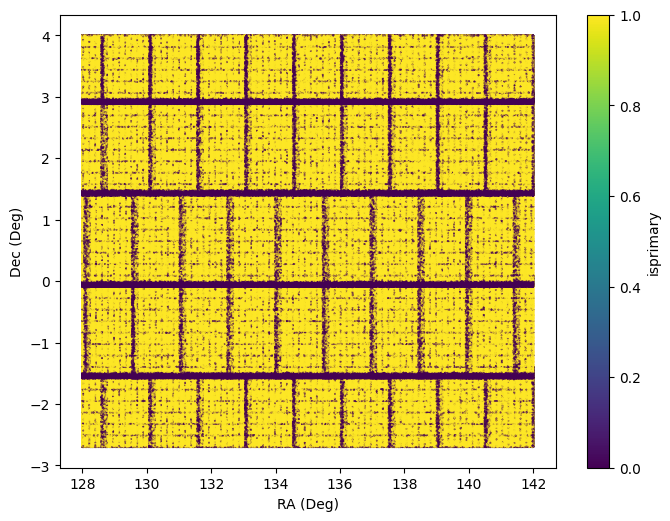

In [34]:
# plot ra/dec with flag on colour
plt.figure(figsize=(8,6),dpi=100)
# plt.hexbin(allrands['ra'],allrands['dec'])
plt.scatter(allrands['ra'],allrands['dec'],c=allrands['isprimary'],s=0.1)
plt.xlabel('RA (Deg)')
plt.ylabel('Dec (Deg)')
cb = plt.colorbar()
cb.set_label('isprimary')

Text(0.5, 1.0, 'G09 all rands isprimary == True')

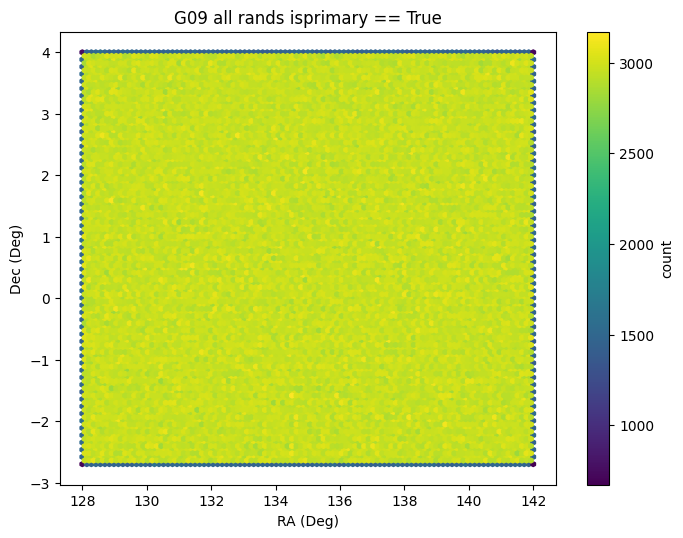

In [4]:
# now plot isprimary == True rands
plt.figure(figsize=(8,6),dpi=100)
plt.hexbin(isprimrands['ra'],isprimrands['dec'])
#plt.scatter(allrands['ra'],allrands['dec'],c=allrands['isprimary'],s=0.1)
plt.xlabel('RA (Deg)')
plt.ylabel('Dec (Deg)')
cb = plt.colorbar()
cb.set_label('count')
plt.title("G09 all rands isprimary == True")

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Text(0, 0.5, 'count')

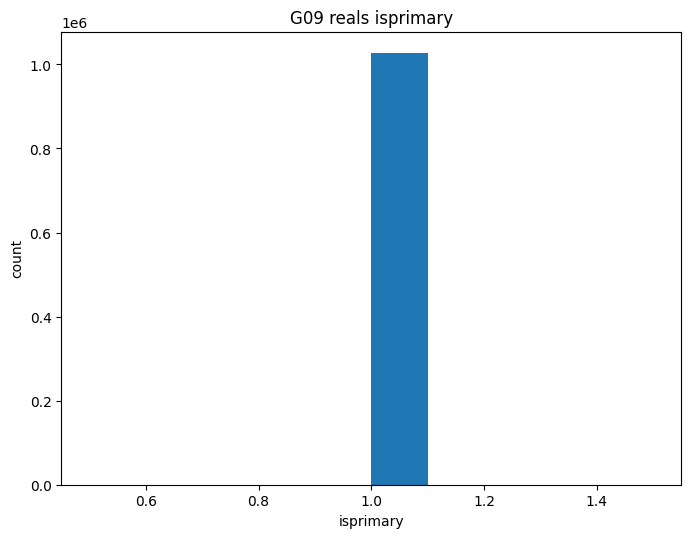

In [75]:
# look at isprim data for reals
realsflags = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09_real_flags.fits')
plt.figure(figsize=(8,6),dpi=100)
plt.hist(realsflags['isprimary'])
plt.xlabel("isprimary")
plt.title("G09 reals isprimary")
plt.ylabel("count")

In [71]:
# real data is all primary!

count = 0
for i in range(len(realsisprim)):
    if realsflags['isprimary'][i] == 0:
        count +=1
        
print(count)

0


In [74]:
# read in unknowns, look at flags
unks = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09_HSC_unknowns.fits')
unks.info()

<Table length=296958>
            name             dtype     class     n_bad 
--------------------------- ------- ------------ ------
                  object_id   int64 MaskedColumn      0
           object_id_isnull    bool       Column      0
                         ra float64       Column      0
                  ra_isnull    bool       Column      0
                        dec float64       Column      0
                 dec_isnull    bool       Column      0
              photoz_median float32       Column      0
       photoz_median_isnull    bool       Column      0
              i_psfflux_mag float32 MaskedColumn   5454
       i_psfflux_mag_isnull    bool       Column      0
              r_psfflux_mag float32 MaskedColumn   7703
       r_psfflux_mag_isnull    bool       Column      0
             r_kronflux_mag float32 MaskedColumn  19500
      r_kronflux_mag_isnull    bool       Column      0
             i_kronflux_mag float32 MaskedColumn  18966
      i_kronflux_mag_isnul

In [76]:
# left join flag data to unks
unks = join(unks,realsflags,keys='object_id',join_type='left')
unks.info()

<Table length=296958>
                  name                   dtype     class     n_bad 
--------------------------------------- ------- ------------ ------
                              object_id   int64 MaskedColumn      0
                     object_id_isnull_1    bool       Column      0
                                     ra float64       Column      0
                              ra_isnull    bool       Column      0
                                    dec float64       Column      0
                             dec_isnull    bool       Column      0
                          photoz_median float32       Column      0
                   photoz_median_isnull    bool       Column      0
                          i_psfflux_mag float32 MaskedColumn   5454
                   i_psfflux_mag_isnull    bool       Column      0
                          r_psfflux_mag float32 MaskedColumn   7703
                   r_psfflux_mag_isnull    bool       Column      0
                         r

In [77]:
unks.write('/suphys/fscu5535/HSC_work/mod_data/G09_HSC_unknowns.fits',overwrite=True)

Text(0.5, 1.0, 'unks dist')

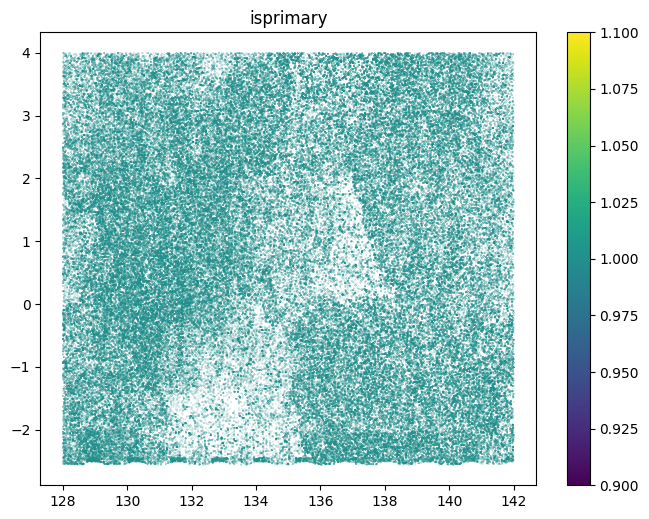

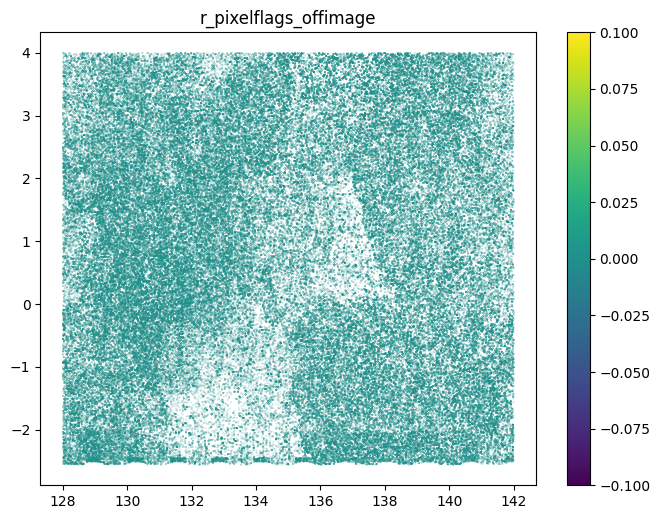

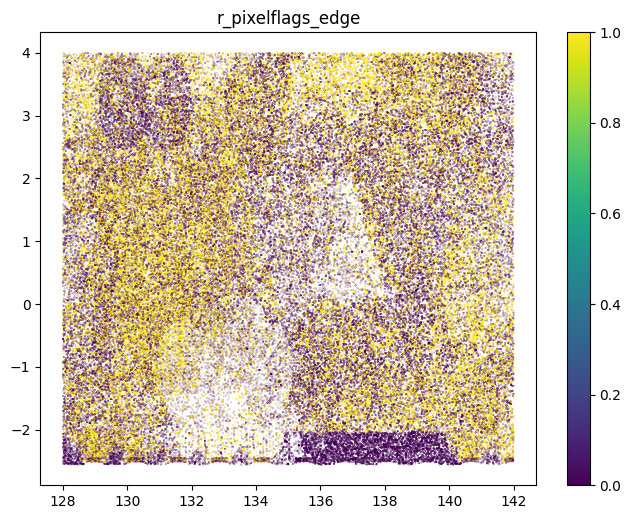

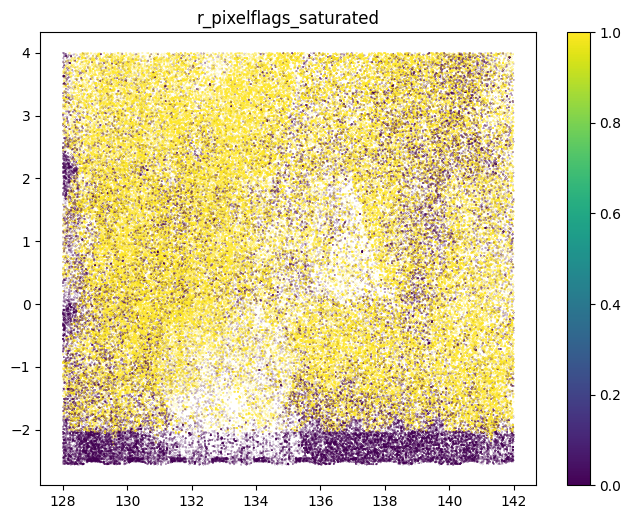

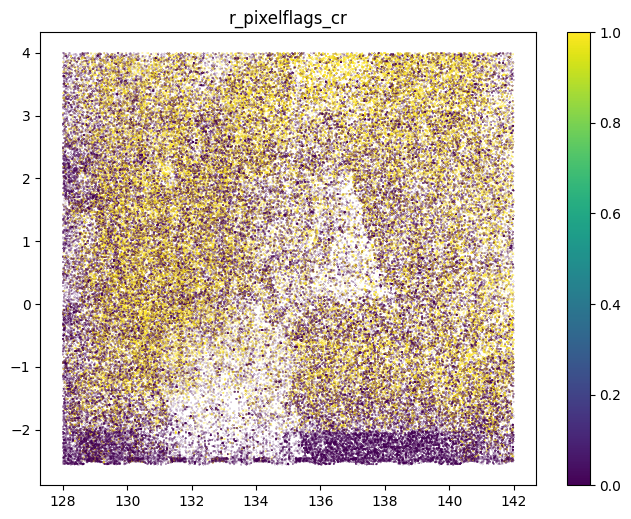

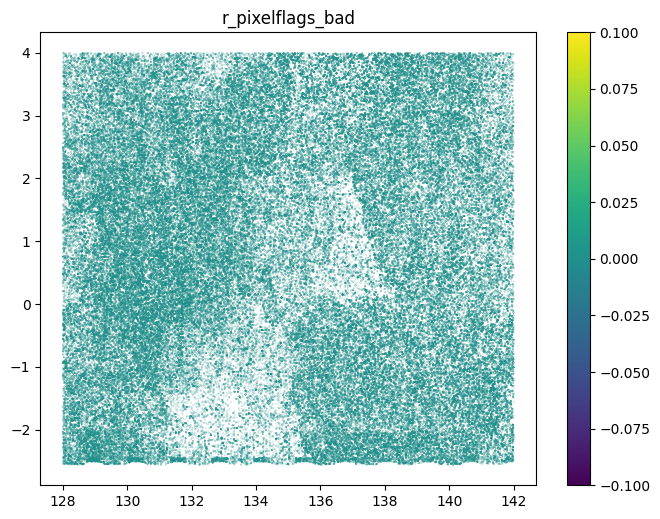

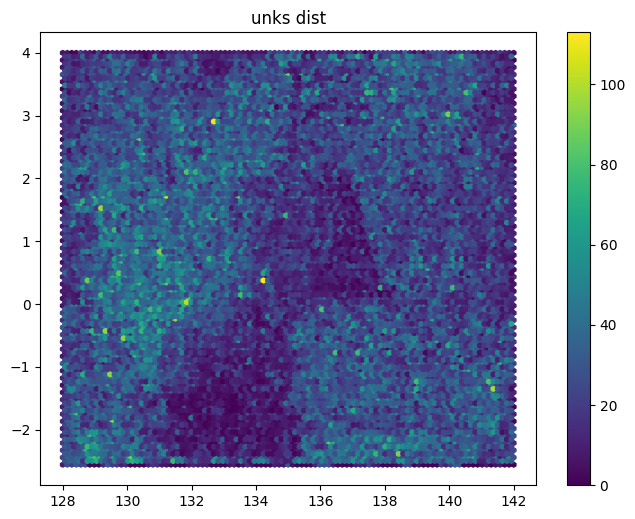

In [11]:
unks = Table.read('/suphys/fscu5535/HSC_work/mod_data/G09_HSC_unknowns.fits')

#plt.figure(figsize=(8,6),dpi=100)

for i in ['isprimary','r_pixelflags_offimage', 'r_pixelflags_edge',
          'r_pixelflags_saturated', 'r_pixelflags_cr','r_pixelflags_bad']:
#     vals, bins, patches = plt.hist(unks[i],histtype='step', fill=False, label=i)
#     print(i)
#     print(vals)
#     print(bins)
#     print()
    plt.figure(figsize=(8,6),dpi=100)
    plt.scatter(unks['ra'],unks['dec'],c=unks[i],s=0.01)
    cb = plt.colorbar()
    plt.title(i)
    
  
plt.figure(figsize=(8,6),dpi=100)
plt.hexbin(unks['ra'],unks['dec'])
cb = plt.colorbar()
plt.title('unks dist')


# plt.title("G09 unknowns flags")
# plt.xlabel('Flag value')
# plt.legend(loc='upper center')
# plt.ylabel('Count')


    

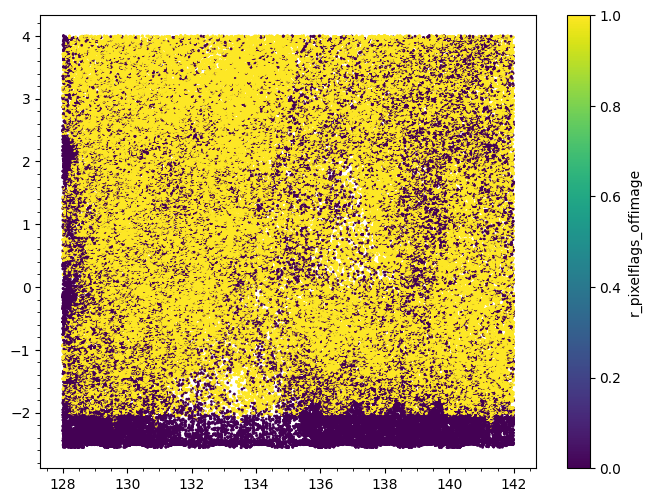

In [103]:
plt.figure(figsize=(8,6),dpi=100)
plt.scatter(unks['ra'],unks['dec'],c=unks['r_pixelflags_saturated'],s=1)
plt.minorticks_on()
cb = plt.colorbar()
cb.set_label('r_pixelflags_offimage')


In [12]:
sami = Table.read('/suphys/fscu5535/python_scripts/raw_data/jvds_stelkin_cat_v012_mge_seecorr_kh20_v20220604_private.fits')
sami.info()

<Table length=3430>
      name       dtype     class     n_bad
--------------- ------- ------------ -----
          CATID   int64       Column     0
      CATID_EXT   int64       Column     0
  SAMI_FILENAME bytes69       Column     0
       OBS_DATE bytes21       Column     0
             RA float32       Column     0
            DEC float32       Column     0
         LMSTAR float32       Column     0
         Z_SPEC float32       Column     0
        Z_TONRY float32 MaskedColumn   984
        GMINUSI float32       Column     0
       MU_AT_RE float32 MaskedColumn   984
       GAL_FLAG float32       Column     0
       HWHM_PSF float32       Column     0
             RE float32 MaskedColumn    53
    RE_CIRC_KPC float32 MaskedColumn    53
          ELLIP float32 MaskedColumn    52
       N_SERSIC float32 MaskedColumn   108
          MTYPE float32       Column     0
      KIN_MTYPE float32       Column     0
ENV_DIST_TO_5NN float32 MaskedColumn   130
   ENV_SURFDENS float32 MaskedColu

In [14]:
print(np.median(sami['Z_SPEC']))
print(np.mean(sami['Z_SPEC']))

0.04461712
0.04425473


In [15]:
print(np.max(sami['Z_SPEC']))

0.12814
